In [9]:
pip install tensorboardX

  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl (101 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge monai=1.3.2


Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing necessary libraries for logging, file handling, and system operations
import logging  # Provides a flexible framework for emitting log messages from Python programs.
import os  # Provides a way of using operating system-dependent functionality, such as reading or writing to the file system.
import shutil  # Used for high-level file operations, such as copying or removing files and directories.
import sys  # Provides access to some variables used or maintained by the Python interpreter and to functions that interact with the interpreter.
import tempfile  # Used to create temporary files and directories.
import random  # Implements pseudo-random number generators for various distributions.
import numpy as np  # Fundamental package for scientific computing with Python, providing support for large, multi-dimensional arrays and matrices.
from tqdm import trange  # Provides a progress bar for loops, making it easier to track long-running tasks.
import matplotlib.pyplot as plt  # A plotting library used for creating static, animated, and interactive visualizations in Python.
import torch  # PyTorch, an open-source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing.
from skimage.util import random_noise  # A function to add random noise of various types to an image.
# Importing functions and classes from the MONAI library, a deep learning framework specialized for healthcare imaging
from monai.apps import download_and_extract  # Utility to download and extract files, particularly useful for datasets.
from monai.config import print_config  # Prints the current configuration of MONAI, including the environment, installed packages, and versions.
from monai.data import CacheDataset, DataLoader  # CacheDataset caches data and is useful for datasets that fit in memory. DataLoader is used to load the data in batches.
from monai.networks.nets import AutoEncoder, SwinUNETR  # Importing an AutoEncoder model, which is a type of neural network used for unsupervised learning, particularly for dimensionality reduction.
from monai.transforms import (  # Importing various transformations to be applied to the data.
    EnsureChannelFirstD,  # Ensures the channel dimension is first in the data tensor.
    Compose,  # Allows the chaining of multiple transformations to be applied sequentially.
    LoadImageD,  # Loads images from a file.
    RandFlipD,  # Randomly flips the image along a specified axis.
    RandRotateD,  # Randomly rotates the image within a specified angle range.
    RandZoomD,  # Randomly zooms in or out of the image within a specified range.
    ScaleIntensityD,  # Scales the intensity of the image to a specified range.
    EnsureTypeD,  # Ensures the output is of a specific data type.
    Lambda,  # Allows for custom transformations using a lambda function.
    #AddChannelD
)
from monai.utils import set_determinism  # Sets the seed for random number generators to ensure reproducibility.
from monai.networks.utils import copy_model_state
from monai.networks.nets.swin_unetr import filter_swinunetr
from monai.transforms import RandSpatialCropd
import math
import warnings
from typing import List

from torch import nn as nn
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import LambdaLR, _LRScheduler
import os
import random
import glob
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
# Print the current MONAI configuration
print_config()
from pre_processing_py import HandScanDataset2, train_df, valid_df, training_data_dir
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time
import torch.nn.functional as F
import psutil  # For memory tracking
import gc


MONAI version: 1.3.2
Numpy version: 1.24.3
Pytorch version: 2.1.0.post100
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: /Users/<username>/anaconda3/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
scipy version: 1.11.1
Pillow version: 10.2.0
Tensorboard version: 2.17.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2a0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 6.0.0
pandas version: 2.0.3
einops version: 0.8.0
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://doc

In [3]:
# Set up basic logging configuration to output log messages to the console (stdout).
# The logging level is set to INFO, meaning all messages at this level and above
# (INFO, WARNING, ERROR, CRITICAL) will be displayed.
logging.basicConfig(stream=sys.stdout, level=logging.INFO)


# Set deterministic behavior for reproducibility. This is important in experiments where
# you want to ensure that the results are the same every time the code is run. 
# The seed value is set to 0, which will be used to initialize the random number generator.
set_determinism(0)

# Determine the device to run the computations on. If a CUDA-capable GPU is available,
# the device will be set to "cuda" (meaning GPU); otherwise, it will fall back to "cpu".
# This allows the code to take advantage of GPU acceleration if possible.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
import matplotlib.pyplot as plt
import torch

def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        
        # Convert numpy array to a compatible data type if needed
        if isinstance(im, np.ndarray):
            im = im.astype(np.float32)  # Convert to a supported type like float32
            im = torch.from_numpy(im)
        
        # Squeeze the image if it's a tensor
        if isinstance(im, torch.Tensor):
            im = torch.squeeze(im)
        
        plt.imshow(im, cmap="gray")
        
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (512, 288)
Loaded image with shape: (51

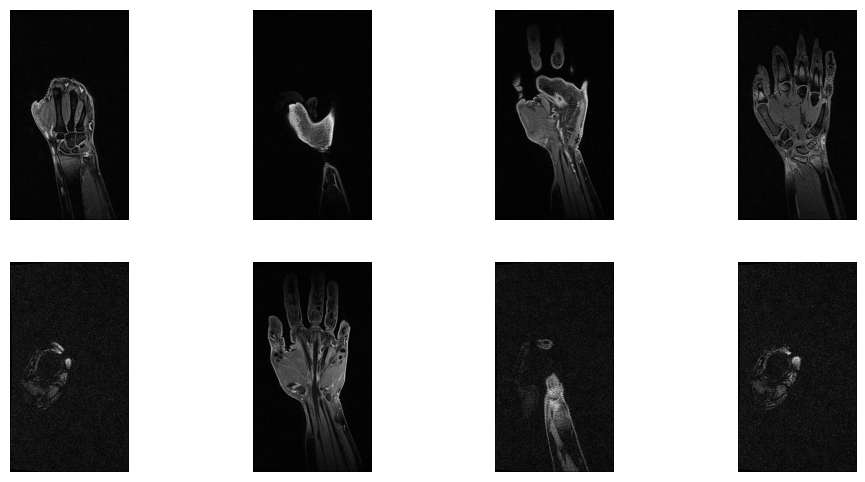

In [5]:

# Define a function to load DICOM images from a directory
def load_dicom_images(directory):
    dicom_files = []
    for image_path in glob.glob(os.path.join(directory, '*')):
        if os.path.isfile(image_path):  # Check if the path is a file (not a directory)
            try:
                dicom_file = pydicom.dcmread(image_path)
                dicom_files.append(dicom_file)
            except Exception as e:
                print(f"Error reading {image_path}: {e}")
    return dicom_files

# Define a function to extract pixel data from DICOM files
def extract_pixel_data(dicom_files):
    images = []
    for dicom_data in dicom_files:
        if hasattr(dicom_data, 'pixel_array'):  # Check if pixel data is present
            image = dicom_data.pixel_array
            images.append(image)
            print(f"Loaded image with shape: {image.shape}")  # Print the shape of each image
    return images

# Function to plot images
def plot_ims(images, shape):
    fig, axes = plt.subplots(shape[0], shape[1], figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Directory containing the images
data_dir = '/Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_28/9730895c1e/t1_vibe_we'  # Replace with the path to your DICOM files

# Load DICOM images from the directory
dicom_files = load_dicom_images(data_dir)

# Extract pixel data from the loaded DICOM files
images = extract_pixel_data(dicom_files)

# Check if there are any images loaded
if images:
    # Select random images
    rand_indices = np.random.choice(len(images), 8, replace=False)

    # Get the images corresponding to the random indices
    rand_images = [images[i] for i in rand_indices]
    
    # Visualize selected images
    plot_ims(rand_images, shape=(2, 4))
else:
    print(f"No images found in directory: {data_dir}")


In [6]:
'''
# Define a custom transformation using MONAI's Lambda transform.
# The transformation applies two types of noise to the image: Gaussian noise and Salt & Pepper noise.
# It creates a dictionary with three keys: "orig" (original image), "gaus" (image with Gaussian noise),
# and "s&p" (image with Salt & Pepper noise).
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],  # Original image
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),  # Gaussian noise
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),  # Salt & Pepper noise
    }
)

# Define the set of transformations to apply to the training data.
train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),  # Load the image from file
        EnsureChannelFirstD(keys=["im"]),  # Ensure the image has the channel dimension first (e.g., [C, H, W])
        ScaleIntensityD(keys=["im"]),  # Scale the intensity of the image to a specific range (default 0 to 1)
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),  # Randomly rotate the image
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),  # Randomly flip the image along the specified axis
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),  # Randomly zoom in/out on the image
        EnsureTypeD(keys=["im"]),  # Ensure the image is a PyTorch tensor with appropriate data type
        NoiseLambda,  # Apply the custom noise transformation
    ]
)

# Define the set of transformations to apply to the test data.
test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),  # Load the image from file
        EnsureChannelFirstD(keys=["im"]),  # Ensure the image has the channel dimension first
        ScaleIntensityD(keys=["im"]),  # Scale the intensity of the image to a specific range
        EnsureTypeD(keys=["im"]),  # Ensure the image is a PyTorch tensor with appropriate data type
        NoiseLambda,  # Apply the custom noise transformation
    ]
)
'''

'\n# Define a custom transformation using MONAI\'s Lambda transform.\n# The transformation applies two types of noise to the image: Gaussian noise and Salt & Pepper noise.\n# It creates a dictionary with three keys: "orig" (original image), "gaus" (image with Gaussian noise),\n# and "s&p" (image with Salt & Pepper noise).\nNoiseLambda = Lambda(\n    lambda d: {\n        "orig": d["im"],  # Original image\n        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),  # Gaussian noise\n        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),  # Salt & Pepper noise\n    }\n)\n\n# Define the set of transformations to apply to the training data.\ntrain_transforms = Compose(\n    [\n        LoadImageD(keys=["im"]),  # Load the image from file\n        EnsureChannelFirstD(keys=["im"]),  # Ensure the image has the channel dimension first (e.g., [C, H, W])\n        ScaleIntensityD(keys=["im"]),  # Scale the intensity of the image to a spe

In [7]:
'''

NoiseLambda = Lambda(
    lambda d: {
        "im": d["im"],  # Preserve the original image key
        "orig": d["im"].clone(),  # Store a copy of the original image
        "gaus": torch.tensor(random_noise(d["im"].numpy(), mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"].numpy(), mode="s&p", salt_vs_pepper=0.1), dtype=torch.float32),
    }
)


train_transforms = Compose(
    [
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)'''

from monai.transforms import Compose, ScaleIntensityD, RandRotateD, RandFlipD, RandZoomD, EnsureTypeD, Lambda
import torch
import numpy as np
from skimage.util import random_noise
'''
# Save the original image before applying transformations
SaveOriginalLambda = Lambda(
    lambda d: {
        "im": d["im"],  # Original image key
        "orig": d["im"].clone(),  # Save a clone of the original image
    }
)

# Add noise transformations while preserving the original
NoiseLambda = Lambda(
    lambda d: {
        **d,  # Keep the original keys
        "gaus": torch.tensor(random_noise(d["orig"].numpy(), mode="gaussian"), dtype=torch.float32),  # Gaussian noise on original
        "s&p": torch.tensor(random_noise(d["orig"].numpy(), mode="s&p", salt_vs_pepper=0.1), dtype=torch.float32),  # Salt & Pepper noise on original
    }
)'''
'''
train_transforms = Compose(
    [
        # AddChannelD(keys=["im"]),
        SaveOriginalLambda,  # Save the original image before any transformations
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["im"]),
        #NoiseLambda,  # Apply noise to the stored original image
    ]
)

test_transforms = Compose(
    [
        # AddChannelD(keys=["im"]),
        SaveOriginalLambda,  # Save the original image before applying noise
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        #NoiseLambda,  # Apply noise to the stored original image
    ]
)'''

train_transforms = RandSpatialCropd(keys=["im"], roi_size=(96, 96, 96), random_center=True, random_size=False)
test_transforms = RandSpatialCropd(keys=["im"], roi_size=(96, 96, 96), random_center=True, random_size=False)


In [8]:
batch_size = 1
num_workers = 0

# Select a few subjects (e.g., the first three subjects)
train_subset_df = train_df.iloc[:80]
# Initialize the dataset with the selected subjects
train_ds = HandScanDataset2(labels_df=train_subset_df, data_dir=training_data_dir, transform=train_transforms)
# Create a data loader for testing
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Select a few subjects (e.g., the first three subjects)
valid_subset_df = valid_df.iloc[:20]
# Initialize the dataset with the selected subjects
train_dataset = HandScanDataset2(labels_df=valid_subset_df, data_dir=training_data_dir, transform=test_transforms)
# Create a data loader for testing
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
# Define the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.activation_count = 0

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.activation_count += 1
                return True
        return False

# Instantiate EarlyStopper
early_stopper = EarlyStopper(patience=3, min_delta=0.001)

In [11]:
import matplotlib.pyplot as plt

def plot_loss_curves(loss_values, val_loss_values, early_stop_epoch):
    """
    Plots the training and validation loss curves.

    Args:
        loss_values (list): List of training loss values.
        val_loss_values (list): List of validation loss values.
        early_stop_epoch (int): Epoch at which early stopping was triggered.
    """
    # Convert the loss values to NumPy arrays for easier manipulation
    loss_values = np.array(loss_values)
    val_loss_values = np.array(val_loss_values)

    # Figure out how many epochs there were
    epochs = range(len(loss_values))

    # Setup a plot
    plt.figure(figsize=(10, 5))

    # Plot the loss
    plt.plot(epochs, loss_values, label='Training Loss')
    plt.plot(epochs, val_loss_values, label='Validation Loss')
    plt.axvline(x=early_stop_epoch, color='red', linestyle='--', label='Early Stop Epoch')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



In [12]:
'''def train(dict_key_for_training, max_epochs=10, learning_rate=1e-3):
    model = AutoEncoder(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(4, 8, 16, 32),
        strides=(2, 2, 2, 2),
    ).to(device)

    # Create loss function and optimizer
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    epoch_loss_values = []

    t = trange(max_epochs, desc=f"{dict_key_for_training} -- epoch 0, avg loss: inf", leave=True)
    for epoch in t:
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1

            # Check if the key exists in batch_data
            if dict_key_for_training not in batch_data:
                raise KeyError(f"Key '{dict_key_for_training}' not found in batch data. Available keys: {batch_data.keys()}")

            inputs = batch_data[dict_key_for_training].squeeze(dim=2).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            # Ensure the "orig" key is present
            if "orig" not in batch_data:
                raise KeyError("'orig' key not found in batch data. Available keys: {batch_data.keys()}")
            loss = loss_function(outputs, batch_data["orig"].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        t.set_description(
            f"{dict_key_for_training} -- epoch {epoch + 1}" + f", average loss: {epoch_loss:.4f}"
        )
    
    return model, epoch_loss_values
'''

'def train(dict_key_for_training, max_epochs=10, learning_rate=1e-3):\n    model = AutoEncoder(\n        spatial_dims=3,\n        in_channels=1,\n        out_channels=1,\n        channels=(4, 8, 16, 32),\n        strides=(2, 2, 2, 2),\n    ).to(device)\n\n    # Create loss function and optimizer\n    loss_function = torch.nn.MSELoss()\n    optimizer = torch.optim.Adam(model.parameters(), learning_rate)\n\n    epoch_loss_values = []\n\n    t = trange(max_epochs, desc=f"{dict_key_for_training} -- epoch 0, avg loss: inf", leave=True)\n    for epoch in t:\n        model.train()\n        epoch_loss = 0\n        step = 0\n        for batch_data in train_loader:\n            step += 1\n\n            # Check if the key exists in batch_data\n            if dict_key_for_training not in batch_data:\n                raise KeyError(f"Key \'{dict_key_for_training}\' not found in batch data. Available keys: {batch_data.keys()}")\n\n            inputs = batch_data[dict_key_for_training].squeeze(dim=2)

In [13]:
'''output_dir = "./output"
log_dir = "./logs"

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Contrastive Loss Function
def contrastive_loss(zsim, zlabel, alpha=0.05):
    bce_loss = nn.BCEWithLogitsLoss()
    return alpha * bce_loss(zsim, zlabel)

def train(dict_key_for_training, max_epochs=10, learning_rate=1e-3, alpha=0.05, patience=5):
    model = AutoEncoder(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(4, 8, 16, 32),
        strides=(2, 2, 2, 2),
    ).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=patience)

    epoch_loss_values = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1

            if dict_key_for_training not in batch_data:
                raise KeyError(f"Key '{dict_key_for_training}' not found in batch data. Available keys: {batch_data.keys()}")

            inputs = batch_data[dict_key_for_training].squeeze(dim=2).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            if "orig" not in batch_data:
                raise KeyError("'orig' key not found in batch data. Available keys: {batch_data.keys()}")

            loss = loss_function(outputs, batch_data["orig"].to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)

        logger.info(f"Epoch {epoch + 1}/{max_epochs}, Loss: {epoch_loss:.4f}")

        # Validation loop
        total_val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch_data in test_loader:
                inputs = batch_data[dict_key_for_training].squeeze(dim=2).to(device)
                outputs = model(inputs)

                loss_L1 = loss_function(outputs, batch_data["orig"].to(device))
                total_val_loss += loss_L1.item()

        avg_val_loss = total_val_loss / len(test_loader)
        logger.info(f"Validation Loss: {avg_val_loss:.4f}")

        # Early stopping check
        if early_stopper.early_stop(avg_val_loss):
            if early_stopper.activation_count == 1:
                logger.info(f"\nEarly stopping criteria reached!\nSaving model parameters to {output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth\n")
                opt_model_filepath = f"{output_dir}/optimal_model_weights_epoch_{epoch + 1}.pth"
                torch.save(model.state_dict(), opt_model_filepath)

        # Logging to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)

    return model, epoch_loss_values
'''

'output_dir = "./output"\nlog_dir = "./logs"\n\n# Set up basic logging\nlogging.basicConfig(level=logging.INFO)\nlogger = logging.getLogger("swin_transformer_3d")\n\n# Create a TensorBoard writer\nwriter = SummaryWriter(log_dir=log_dir)\n\n# Contrastive Loss Function\ndef contrastive_loss(zsim, zlabel, alpha=0.05):\n    bce_loss = nn.BCEWithLogitsLoss()\n    return alpha * bce_loss(zsim, zlabel)\n\ndef train(dict_key_for_training, max_epochs=10, learning_rate=1e-3, alpha=0.05, patience=5):\n    model = AutoEncoder(\n        spatial_dims=3,\n        in_channels=1,\n        out_channels=1,\n        channels=(4, 8, 16, 32),\n        strides=(2, 2, 2, 2),\n    ).to(device)\n\n    loss_function = nn.MSELoss()\n    optimizer = optim.Adam(model.parameters(), lr=learning_rate)\n    early_stopper = EarlyStopper(patience=patience)\n\n    epoch_loss_values = []\n\n    for epoch in range(max_epochs):\n        model.train()\n        epoch_loss = 0\n        step = 0\n        for batch_data in train_

In [14]:
from monai.apps import download_url
pre_training_weights_path='/Users/eleanorbolton/Documents/project_repo/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/Predicting-Rheumatoid-Arthritis-Progression-Using-Hand-MRI-Scans-from-At-Risk-Patients/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/src/models/ssl_pretrained_weights.pth'

swin_model = SwinUNETR(
    img_size=(32, 96, 96),
    in_channels=1,
    out_channels=1,  
    feature_size=48,  # Match the pre-trained model
    depths=(2, 2, 2, 2),  # Match the pre-trained model
    num_heads=(3, 6, 12, 24),  # Match the pre-trained model
    spatial_dims=3,
    use_checkpoint=False  # You can keep this as True if you need it
)

resource = (
    "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/ssl_pretrained_weights.pth"
)
download_url(resource, pre_training_weights_path)
ssl_weights = torch.load(pre_training_weights_path, map_location=torch.device('cpu'))["model"]

dst_dict, loaded, not_loaded = copy_model_state(swin_model, ssl_weights, filter_func=filter_swinunetr)

/Users/eleanorbolton/anaconda3/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


2024-08-27 13:56:19,903 - INFO - Expected md5 is None, skip md5 check for file /Users/eleanorbolton/Documents/project_repo/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/Predicting-Rheumatoid-Arthritis-Progression-Using-Hand-MRI-Scans-from-At-Risk-Patients/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/src/models/ssl_pretrained_weights.pth.
2024-08-27 13:56:19,903 - INFO - File exists: /Users/eleanorbolton/Documents/project_repo/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/Predicting-Rheumatoid-Arthritis-Progression-Using-Hand-MRI-Scans-from-At-Risk-Patients/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/src/models/ssl_pretrained_weights.pth, skipped downloading.
2024-08-27 13:56:20,366 - INFO - 'dst' model updated: 159 of 159 variables.


In [15]:
# Freeze specific layers if you don't want them to be updated during fine-tuning
for name, param in swin_model.named_parameters():
    if "swinViT.layers1" in name or "swinViT.layers2" in name:
        param.requires_grad = False  # Freeze these layers


# Freeze specific layers if you don't want them to be updated during fine-tuning
for name, param in swin_model.named_parameters():
    if "patch_embed" in name:
        param.requires_grad = False  # Freeze these layers


for name, param in swin_model.named_parameters():
    if 'encoder' in name and 'encoder4' not in name and 'encoder10' not in name:
        param.requires_grad = False  # Freeze these layers

# Freeze some parts of the decoder if needed
for name, param in swin_model.named_parameters():
     if 'decoder' in name and 'decoder4' not in name and 'decoder5' not in name:
         param.requires_grad = False

# Print which layers will be fine-tuned
for name, param in swin_model.named_parameters():
    if param.requires_grad:
        print(f"Fine-tuning layer: {name}")

Fine-tuning layer: swinViT.layers3.0.blocks.0.norm1.weight
Fine-tuning layer: swinViT.layers3.0.blocks.0.norm1.bias
Fine-tuning layer: swinViT.layers3.0.blocks.0.attn.relative_position_bias_table
Fine-tuning layer: swinViT.layers3.0.blocks.0.attn.qkv.weight
Fine-tuning layer: swinViT.layers3.0.blocks.0.attn.qkv.bias
Fine-tuning layer: swinViT.layers3.0.blocks.0.attn.proj.weight
Fine-tuning layer: swinViT.layers3.0.blocks.0.attn.proj.bias
Fine-tuning layer: swinViT.layers3.0.blocks.0.norm2.weight
Fine-tuning layer: swinViT.layers3.0.blocks.0.norm2.bias
Fine-tuning layer: swinViT.layers3.0.blocks.0.mlp.linear1.weight
Fine-tuning layer: swinViT.layers3.0.blocks.0.mlp.linear1.bias
Fine-tuning layer: swinViT.layers3.0.blocks.0.mlp.linear2.weight
Fine-tuning layer: swinViT.layers3.0.blocks.0.mlp.linear2.bias
Fine-tuning layer: swinViT.layers3.0.blocks.1.norm1.weight
Fine-tuning layer: swinViT.layers3.0.blocks.1.norm1.bias
Fine-tuning layer: swinViT.layers3.0.blocks.1.attn.relative_position_b

In [16]:
# Define path to where I will save results
ResultsPath = '/Users/eleanorbolton/Documents/project_repo/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/Predicting-Rheumatoid-Arthritis-Progression-Using-Hand-MRI-Scans-from-At-Risk-Patients/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/src/results'
os.makedirs(ResultsPath, exist_ok=True)
ResultsPath

'/Users/eleanorbolton/Documents/project_repo/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/Predicting-Rheumatoid-Arthritis-Progression-Using-Hand-MRI-Scans-from-At-Risk-Patients/predicting-rheumatoid-arthritis-progression-using-hand-mri-scans-from-at-risk-patients/src/results'

In [17]:
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from monai.networks.nets import SwinUNETR  # Import SwinUNETR from MONAI
from monai.data import DataLoader
from monai.utils import set_determinism

# Initialize paths

log_dir = ResultsPath

# Set up basic logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("swin_transformer_3d")

# Create a TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)


# Training function using SwinUNETR
def train(train_loader, test_loader, max_epochs=10, learning_rate=1e-3, patience=5, model=None):
    # Initialize the SwinUNETR model
    logger.info('Initializing model')

    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopper = EarlyStopper(patience=patience)

    epoch_loss_values = []

    for epoch in range(max_epochs):
        epoch_start_time = time.time()
        model.train()
        epoch_loss = 0
        step = 0

        # Progress bar for the epoch
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{max_epochs}", unit="batch") as pbar:
            for batch_data in train_loader:
                batch_start_time = time.time()
                step += 1

                inputs = batch_data["im"].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)

                loss = loss_function(outputs, inputs.to(device))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

                batch_time = time.time() - batch_start_time
                pbar.set_postfix({"Batch Time": f"{batch_time:.4f} sec"})
                pbar.update(1)

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)

        logger.info(f"Epoch {epoch + 1}/{max_epochs}, Loss: {epoch_loss:.4f}")

        # Validation loop with progress bar
        total_val_loss = 0.0
        model.eval()
        with tqdm(total=len(test_loader), desc="Validation", unit="batch") as pbar:
            with torch.no_grad():
                for batch_data in test_loader:
                    inputs = batch_data["im"].to(device)
                    outputs = model(inputs)

                    loss_L1 = loss_function(outputs, inputs.to(device))
                    total_val_loss += loss_L1.item()
                    pbar.update(1)

        avg_val_loss = total_val_loss / len(test_loader)
        logger.info(f"Validation Loss: {avg_val_loss:.4f}")

        epoch_time = time.time() - epoch_start_time
        logger.info(f"Epoch {epoch + 1} took {epoch_time:.4f} seconds")

        # Early stopping check
        if early_stopper.early_stop(avg_val_loss):
            # Save model parameters if early stopping criteria are met for the first time
            if early_stopper.counter == 1:
                logger.info(f"\nEarly stopping criteria reached!\nSaving model parameters to {ResultsPath}/optimal_model_weights_epoch_{epoch + 1}.pth\n")
                opt_model_filepath = f"{ResultsPath}/optimal_model_weights_epoch_{epoch + 1}.pth"
                torch.save(model.state_dict(), opt_model_filepath)

        # Logging to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Loss/validation', avg_val_loss, epoch)

    return model, epoch_loss_values



In [18]:
# Set hyperparameters
max_epochs = 100
learning_rate = 1e-2
patience = 3
models = []
epoch_losses = []

# Run the training function
model, epoch_loss = train(train_loader, test_loader, max_epochs=max_epochs, learning_rate=learning_rate, patience=patience, model=swin_model)

# Store the trained model and loss values
models.append(model)
epoch_losses.append(epoch_loss)

# Save the model and state dict after training
model_path = f"{ResultsPath}/swin_unetr_model.pth"
state_dict_path = f"{ResultsPath}/swin_unetr_state_dict.pth"

# Save the full model
torch.save(model, model_path)

# Save only the model's state dict
torch.save({"state_dict": model.state_dict()}, state_dict_path)

logger.info(f"Model saved to {model_path} and state dict saved to {state_dict_path}")


INFO:swin_transformer_3d:Initializing model


Epoch 1/100:  99%|█████████▉| 79/80 [11:10<00:09,  9.23s/batch, Batch Time=8.8072 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 1/100: 100%|██████████| 80/80 [11:19<00:00,  8.49s/batch, Batch Time=8.0268 sec]

INFO:swin_transformer_3d:Epoch 1/100, Loss: 0.1113



Validation: 100%|██████████| 44/44 [04:32<00:00,  6.20s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0799
INFO:swin_transformer_3d:Epoch 1 took 951.9901 seconds



Epoch 2/100:  85%|████████▌ | 68/80 [10:04<01:49,  9.12s/batch, Batch Time=8.3552 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 2/100: 100%|██████████| 80/80 [11:53<00:00,  8.92s/batch, Batch Time=7.8418 sec]

INFO:swin_transformer_3d:Epoch 2/100, Loss: 0.0825



Validation: 100%|██████████| 44/44 [04:07<00:00,  5.61s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0678
INFO:swin_transformer_3d:Epoch 2 took 960.6066 seconds



Epoch 3/100:  86%|████████▋ | 69/80 [10:30<01:41,  9.23s/batch, Batch Time=7.9985 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 3/100: 100%|██████████| 80/80 [12:08<00:00,  9.11s/batch, Batch Time=8.3385 sec] 

INFO:swin_transformer_3d:Epoch 3/100, Loss: 0.0718



Validation: 100%|██████████| 44/44 [04:19<00:00,  5.91s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0733
INFO:swin_transformer_3d:Epoch 3 took 988.4231 seconds



Epoch 4/100:  60%|██████    | 48/80 [08:15<04:49,  9.04s/batch, Batch Time=8.3737 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 4/100: 100%|██████████| 80/80 [13:08<00:00,  9.86s/batch, Batch Time=7.8112 sec] 

INFO:swin_transformer_3d:Epoch 4/100, Loss: 0.0637



Validation: 100%|██████████| 44/44 [04:26<00:00,  6.05s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0659
INFO:swin_transformer_3d:Epoch 4 took 1055.1528 seconds



Epoch 5/100:  60%|██████    | 48/80 [07:18<05:51, 10.99s/batch, Batch Time=10.9356 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 5/100: 100%|██████████| 80/80 [12:43<00:00,  9.54s/batch, Batch Time=8.9079 sec] 

INFO:swin_transformer_3d:Epoch 5/100, Loss: 0.0619



Validation: 100%|██████████| 44/44 [04:42<00:00,  6.43s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0546
INFO:swin_transformer_3d:Epoch 5 took 1046.3345 seconds



Epoch 6/100:  69%|██████▉   | 55/80 [08:36<03:42,  8.90s/batch, Batch Time=7.7784 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 6/100: 100%|██████████| 80/80 [13:06<00:00,  9.83s/batch, Batch Time=7.2275 sec] 

INFO:swin_transformer_3d:Epoch 6/100, Loss: 0.0591



Validation: 100%|██████████| 44/44 [04:20<00:00,  5.92s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0525
INFO:swin_transformer_3d:Epoch 6 took 1046.8368 seconds



Epoch 7/100:  21%|██▏       | 17/80 [02:39<09:24,  8.97s/batch, Batch Time=7.2048 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 7/100: 100%|██████████| 80/80 [12:12<00:00,  9.16s/batch, Batch Time=7.1478 sec] 

INFO:swin_transformer_3d:Epoch 7/100, Loss: 0.0716



Validation: 100%|██████████| 44/44 [04:30<00:00,  6.16s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0520
INFO:swin_transformer_3d:Epoch 7 took 1003.2994 seconds



Epoch 8/100:  98%|█████████▊| 78/80 [11:48<00:17,  8.92s/batch, Batch Time=7.9041 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 8/100: 100%|██████████| 80/80 [12:09<00:00,  9.12s/batch, Batch Time=11.0738 sec]

INFO:swin_transformer_3d:Epoch 8/100, Loss: 0.0576



Validation: 100%|██████████| 44/44 [04:58<00:00,  6.78s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0506
INFO:swin_transformer_3d:Epoch 8 took 1027.6812 seconds



Epoch 9/100:  92%|█████████▎| 74/80 [12:14<00:59,  9.93s/batch, Batch Time=8.6372 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 9/100: 100%|██████████| 80/80 [13:13<00:00,  9.92s/batch, Batch Time=8.0887 sec] 

INFO:swin_transformer_3d:Epoch 9/100, Loss: 0.0588



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.10s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0482
INFO:swin_transformer_3d:Epoch 9 took 1062.0284 seconds



Epoch 10/100:  85%|████████▌ | 68/80 [10:25<01:51,  9.27s/batch, Batch Time=7.1478 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 10/100: 100%|██████████| 80/80 [12:54<00:00,  9.68s/batch, Batch Time=15.8107 sec]

INFO:swin_transformer_3d:Epoch 10/100, Loss: 0.0590



Validation: 100%|██████████| 44/44 [04:43<00:00,  6.44s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0728
INFO:swin_transformer_3d:Epoch 10 took 1057.5936 seconds



Epoch 11/100:  39%|███▉      | 31/80 [04:46<07:34,  9.28s/batch, Batch Time=8.3265 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 11/100: 100%|██████████| 80/80 [12:37<00:00,  9.47s/batch, Batch Time=7.9954 sec] 

INFO:swin_transformer_3d:Epoch 11/100, Loss: 0.0555



Validation: 100%|██████████| 44/44 [04:46<00:00,  6.51s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0594
INFO:swin_transformer_3d:Epoch 11 took 1043.7685 seconds



Epoch 12/100:  75%|███████▌  | 60/80 [09:25<03:13,  9.67s/batch, Batch Time=9.4734 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 12/100: 100%|██████████| 80/80 [12:44<00:00,  9.55s/batch, Batch Time=9.7087 sec] 

INFO:swin_transformer_3d:Epoch 12/100, Loss: 0.0490



Validation: 100%|██████████| 44/44 [05:09<00:00,  7.03s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0539
INFO:swin_transformer_3d:Epoch 12 took 1073.5970 seconds



Epoch 13/100:   0%|          | 0/80 [00:00<?, ?batch/s]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 13/100: 100%|██████████| 80/80 [13:31<00:00, 10.15s/batch, Batch Time=7.1154 sec] 

INFO:swin_transformer_3d:Epoch 13/100, Loss: 0.0535



Validation: 100%|██████████| 44/44 [05:26<00:00,  7.42s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0466
INFO:swin_transformer_3d:Epoch 13 took 1138.4127 seconds



Epoch 14/100:   2%|▎         | 2/80 [00:20<13:36, 10.47s/batch, Batch Time=9.7463 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 14/100: 100%|██████████| 80/80 [12:24<00:00,  9.30s/batch, Batch Time=10.0695 sec]

INFO:swin_transformer_3d:Epoch 14/100, Loss: 0.0501



Validation: 100%|██████████| 44/44 [04:12<00:00,  5.74s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0457
INFO:swin_transformer_3d:Epoch 14 took 996.9177 seconds



Epoch 15/100:  79%|███████▉  | 63/80 [09:27<02:24,  8.47s/batch, Batch Time=7.8426 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 15/100: 100%|██████████| 80/80 [11:58<00:00,  8.98s/batch, Batch Time=7.8859 sec] 

INFO:swin_transformer_3d:Epoch 15/100, Loss: 0.0548



Validation: 100%|██████████| 44/44 [04:17<00:00,  5.86s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0458
INFO:swin_transformer_3d:Epoch 15 took 976.0435 seconds



Epoch 16/100:   9%|▉         | 7/80 [01:04<11:12,  9.22s/batch, Batch Time=8.3218 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 16/100: 100%|██████████| 80/80 [12:03<00:00,  9.05s/batch, Batch Time=11.0614 sec]

INFO:swin_transformer_3d:Epoch 16/100, Loss: 0.0501



Validation: 100%|██████████| 44/44 [04:17<00:00,  5.86s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0440
INFO:swin_transformer_3d:Epoch 16 took 981.6221 seconds



Epoch 17/100:  38%|███▊      | 30/80 [04:55<09:21, 11.23s/batch, Batch Time=11.2513 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 17/100: 100%|██████████| 80/80 [13:03<00:00,  9.79s/batch, Batch Time=8.0863 sec] 

INFO:swin_transformer_3d:Epoch 17/100, Loss: 0.0483



Validation: 100%|██████████| 44/44 [04:40<00:00,  6.37s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0376
INFO:swin_transformer_3d:Epoch 17 took 1063.3986 seconds



Epoch 18/100:  60%|██████    | 48/80 [07:39<04:42,  8.84s/batch, Batch Time=8.0426 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 18/100: 100%|██████████| 80/80 [12:21<00:00,  9.27s/batch, Batch Time=8.4684 sec] 

INFO:swin_transformer_3d:Epoch 18/100, Loss: 0.0465



Validation: 100%|██████████| 44/44 [04:20<00:00,  5.93s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0431
INFO:swin_transformer_3d:Epoch 18 took 1002.4617 seconds



Epoch 19/100:  62%|██████▎   | 50/80 [41:20<04:27,  8.91s/batch, Batch Time=7.2616 sec]      

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 19/100: 100%|██████████| 80/80 [45:59<00:00, 34.49s/batch, Batch Time=7.5992 sec] 

INFO:swin_transformer_3d:Epoch 19/100, Loss: 0.0457



Validation: 100%|██████████| 44/44 [39:09<00:00, 53.39s/batch]   

INFO:swin_transformer_3d:Validation Loss: 0.0493
INFO:swin_transformer_3d:Epoch 19 took 5108.3891 seconds



Epoch 20/100:  32%|███▎      | 26/80 [04:08<08:31,  9.47s/batch, Batch Time=8.0052 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 20/100: 100%|██████████| 80/80 [12:30<00:00,  9.38s/batch, Batch Time=9.1400 sec] 

INFO:swin_transformer_3d:Epoch 20/100, Loss: 0.0457



Validation: 100%|██████████| 44/44 [04:48<00:00,  6.56s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0459
INFO:swin_transformer_3d:Epoch 20 took 1038.9739 seconds



Epoch 21/100:  15%|█▌        | 12/80 [01:50<10:34,  9.33s/batch, Batch Time=7.6128 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 21/100: 100%|██████████| 80/80 [12:02<00:00,  9.03s/batch, Batch Time=8.8760 sec] 

INFO:swin_transformer_3d:Epoch 21/100, Loss: 0.0514



Validation: 100%|██████████| 44/44 [04:26<00:00,  6.07s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0455
INFO:swin_transformer_3d:Epoch 21 took 988.9560 seconds



Epoch 22/100:  32%|███▎      | 26/80 [08:16<12:21, 13.72s/batch, Batch Time=8.6147 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 22/100: 100%|██████████| 80/80 [21:26<00:00, 16.08s/batch, Batch Time=9.1126 sec] 

INFO:swin_transformer_3d:Epoch 22/100, Loss: 0.0449



Validation: 100%|██████████| 44/44 [05:40<00:00,  7.73s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0431
INFO:swin_transformer_3d:Epoch 22 took 1626.8129 seconds



Epoch 23/100:   1%|▏         | 1/80 [00:28<37:04, 28.16s/batch, Batch Time=27.5316 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 23/100: 100%|██████████| 80/80 [21:32<00:00, 16.15s/batch, Batch Time=9.7174 sec] 

INFO:swin_transformer_3d:Epoch 23/100, Loss: 0.0453



Validation: 100%|██████████| 44/44 [04:52<00:00,  6.64s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0382
INFO:swin_transformer_3d:Epoch 23 took 1584.0517 seconds



Epoch 24/100:  57%|█████▊    | 46/80 [06:55<04:55,  8.70s/batch, Batch Time=7.5624 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 24/100: 100%|██████████| 80/80 [12:12<00:00,  9.15s/batch, Batch Time=7.0734 sec] 

INFO:swin_transformer_3d:Epoch 24/100, Loss: 0.0416



Validation: 100%|██████████| 44/44 [04:33<00:00,  6.22s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0387
INFO:swin_transformer_3d:Epoch 24 took 1005.8711 seconds



Epoch 25/100:  72%|███████▎  | 58/80 [09:36<03:39,  9.98s/batch, Batch Time=7.4411 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 25/100: 100%|██████████| 80/80 [12:47<00:00,  9.59s/batch, Batch Time=8.8800 sec]

INFO:swin_transformer_3d:Epoch 25/100, Loss: 0.0460



Validation: 100%|██████████| 44/44 [04:50<00:00,  6.60s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0401
INFO:swin_transformer_3d:Epoch 25 took 1057.7726 seconds



Epoch 26/100:  85%|████████▌ | 68/80 [10:50<01:59,  9.96s/batch, Batch Time=8.4583 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 26/100: 100%|██████████| 80/80 [12:44<00:00,  9.55s/batch, Batch Time=9.7674 sec] 

INFO:swin_transformer_3d:Epoch 26/100, Loss: 0.0416



Validation: 100%|██████████| 44/44 [04:42<00:00,  6.43s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0400
INFO:swin_transformer_3d:Epoch 26 took 1047.1707 seconds



Epoch 27/100:  72%|███████▎  | 58/80 [09:04<03:21,  9.17s/batch, Batch Time=7.7394 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 27/100: 100%|██████████| 80/80 [12:48<00:00,  9.61s/batch, Batch Time=8.6100 sec] 

INFO:swin_transformer_3d:Epoch 27/100, Loss: 0.0428



Validation: 100%|██████████| 44/44 [05:51<00:00,  8.00s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0432
INFO:swin_transformer_3d:Epoch 27 took 1120.9036 seconds



Epoch 28/100:  28%|██▊       | 22/80 [03:36<10:26, 10.81s/batch, Batch Time=10.0797 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 28/100: 100%|██████████| 80/80 [12:36<00:00,  9.45s/batch, Batch Time=10.9253 sec]

INFO:swin_transformer_3d:Epoch 28/100, Loss: 0.0375



Validation: 100%|██████████| 44/44 [04:46<00:00,  6.51s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0375
INFO:swin_transformer_3d:Epoch 28 took 1042.5836 seconds



Epoch 29/100:  75%|███████▌  | 60/80 [10:10<03:00,  9.05s/batch, Batch Time=8.8619 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 29/100: 100%|██████████| 80/80 [13:28<00:00, 10.11s/batch, Batch Time=9.6122 sec] 

INFO:swin_transformer_3d:Epoch 29/100, Loss: 0.0396



Validation: 100%|██████████| 44/44 [04:55<00:00,  6.71s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0390
INFO:swin_transformer_3d:Epoch 29 took 1104.0710 seconds



Epoch 30/100:  81%|████████▏ | 65/80 [10:27<02:16,  9.13s/batch, Batch Time=8.3639 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 30/100: 100%|██████████| 80/80 [12:43<00:00,  9.55s/batch, Batch Time=9.2461 sec]

INFO:swin_transformer_3d:Epoch 30/100, Loss: 0.0412



Validation: 100%|██████████| 44/44 [04:52<00:00,  6.64s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0392
INFO:swin_transformer_3d:Epoch 30 took 1056.1021 seconds



Epoch 31/100:  22%|██▎       | 18/80 [03:01<09:23,  9.10s/batch, Batch Time=7.2822 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 31/100: 100%|██████████| 80/80 [12:38<00:00,  9.48s/batch, Batch Time=9.2883 sec] 

INFO:swin_transformer_3d:Epoch 31/100, Loss: 0.0396



Validation: 100%|██████████| 44/44 [04:38<00:00,  6.33s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0360
INFO:swin_transformer_3d:Epoch 31 took 1037.2492 seconds



Epoch 32/100:  86%|████████▋ | 69/80 [11:23<01:46,  9.64s/batch, Batch Time=8.8568 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 32/100: 100%|██████████| 80/80 [13:10<00:00,  9.89s/batch, Batch Time=8.4326 sec] 

INFO:swin_transformer_3d:Epoch 32/100, Loss: 0.0417



Validation: 100%|██████████| 44/44 [04:38<00:00,  6.32s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0349
INFO:swin_transformer_3d:Epoch 32 took 1068.9303 seconds



Epoch 33/100:  64%|██████▍   | 51/80 [08:20<04:37,  9.58s/batch, Batch Time=8.4301 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 33/100: 100%|██████████| 80/80 [12:58<00:00,  9.73s/batch, Batch Time=8.2614 sec] 

INFO:swin_transformer_3d:Epoch 33/100, Loss: 0.0396



Validation: 100%|██████████| 44/44 [04:46<00:00,  6.51s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0393
INFO:swin_transformer_3d:Epoch 33 took 1064.6264 seconds



Epoch 34/100:  18%|█▊        | 14/80 [02:17<11:01, 10.02s/batch, Batch Time=10.5866 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 34/100: 100%|██████████| 80/80 [12:35<00:00,  9.45s/batch, Batch Time=8.0027 sec] 

INFO:swin_transformer_3d:Epoch 34/100, Loss: 0.0334



Validation: 100%|██████████| 44/44 [04:33<00:00,  6.21s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0423
INFO:swin_transformer_3d:Epoch 34 took 1029.1154 seconds



Epoch 35/100:  99%|█████████▉| 79/80 [11:51<00:08,  8.73s/batch, Batch Time=8.0437 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 35/100: 100%|██████████| 80/80 [12:01<00:00,  9.02s/batch, Batch Time=8.3371 sec]

INFO:swin_transformer_3d:Epoch 35/100, Loss: 0.0386



Validation: 100%|██████████| 44/44 [05:26<00:00,  7.43s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0313
INFO:swin_transformer_3d:Epoch 35 took 1048.2372 seconds



Epoch 36/100:   6%|▋         | 5/80 [00:47<11:54,  9.53s/batch, Batch Time=8.8372 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 36/100: 100%|██████████| 80/80 [12:02<00:00,  9.04s/batch, Batch Time=7.6854 sec]

INFO:swin_transformer_3d:Epoch 36/100, Loss: 0.0422



Validation: 100%|██████████| 44/44 [04:29<00:00,  6.12s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0374
INFO:swin_transformer_3d:Epoch 36 took 992.1297 seconds



Epoch 37/100:  38%|███▊      | 30/80 [04:32<07:28,  8.97s/batch, Batch Time=7.8998 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 37/100: 100%|██████████| 80/80 [12:20<00:00,  9.26s/batch, Batch Time=8.0788 sec] 

INFO:swin_transformer_3d:Epoch 37/100, Loss: 0.0412



Validation: 100%|██████████| 44/44 [04:30<00:00,  6.15s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0352
INFO:swin_transformer_3d:Epoch 37 took 1011.3894 seconds



Epoch 38/100:   6%|▋         | 5/80 [00:47<11:46,  9.42s/batch, Batch Time=8.8431 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 38/100: 100%|██████████| 80/80 [12:15<00:00,  9.20s/batch, Batch Time=8.2629 sec] 

INFO:swin_transformer_3d:Epoch 38/100, Loss: 0.0367



Validation: 100%|██████████| 44/44 [04:36<00:00,  6.28s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0375
INFO:swin_transformer_3d:Epoch 38 took 1012.4326 seconds



Epoch 39/100:  80%|████████  | 64/80 [09:40<02:25,  9.09s/batch, Batch Time=8.1599 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 39/100: 100%|██████████| 80/80 [12:04<00:00,  9.06s/batch, Batch Time=8.4346 sec]

INFO:swin_transformer_3d:Epoch 39/100, Loss: 0.0360



Validation: 100%|██████████| 44/44 [04:27<00:00,  6.09s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0588
INFO:swin_transformer_3d:Epoch 39 took 992.7850 seconds



Epoch 40/100:  19%|█▉        | 15/80 [02:15<09:30,  8.78s/batch, Batch Time=7.7879 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 40/100: 100%|██████████| 80/80 [11:55<00:00,  8.95s/batch, Batch Time=8.8285 sec]

INFO:swin_transformer_3d:Epoch 40/100, Loss: 0.0384



Validation: 100%|██████████| 44/44 [04:26<00:00,  6.05s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0366
INFO:swin_transformer_3d:Epoch 40 took 981.9036 seconds



Epoch 41/100:  30%|███       | 24/80 [03:35<08:21,  8.95s/batch, Batch Time=8.3140 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 41/100: 100%|██████████| 80/80 [11:52<00:00,  8.91s/batch, Batch Time=7.6619 sec]

INFO:swin_transformer_3d:Epoch 41/100, Loss: 0.0374



Validation: 100%|██████████| 44/44 [04:27<00:00,  6.08s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0335
INFO:swin_transformer_3d:Epoch 41 took 980.2887 seconds



Epoch 42/100:  82%|████████▎ | 66/80 [09:48<02:05,  8.94s/batch, Batch Time=7.6040 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 42/100: 100%|██████████| 80/80 [11:55<00:00,  8.94s/batch, Batch Time=8.0436 sec]

INFO:swin_transformer_3d:Epoch 42/100, Loss: 0.0372



Validation: 100%|██████████| 44/44 [04:27<00:00,  6.08s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0360
INFO:swin_transformer_3d:Epoch 42 took 982.7360 seconds



Epoch 43/100:  42%|████▎     | 34/80 [05:07<06:50,  8.93s/batch, Batch Time=8.1210 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 43/100: 100%|██████████| 80/80 [11:58<00:00,  8.98s/batch, Batch Time=8.5174 sec]

INFO:swin_transformer_3d:Epoch 43/100, Loss: 0.0327



Validation: 100%|██████████| 44/44 [04:26<00:00,  6.05s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0321
INFO:swin_transformer_3d:Epoch 43 took 985.0890 seconds



Epoch 44/100:  56%|█████▋    | 45/80 [06:45<05:07,  8.78s/batch, Batch Time=7.7744 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 44/100: 100%|██████████| 80/80 [12:07<00:00,  9.09s/batch, Batch Time=7.7258 sec] 

INFO:swin_transformer_3d:Epoch 44/100, Loss: 0.0363



Validation: 100%|██████████| 44/44 [04:27<00:00,  6.09s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0282
INFO:swin_transformer_3d:Epoch 44 took 995.3980 seconds



Epoch 45/100:  45%|████▌     | 36/80 [05:30<06:35,  8.99s/batch, Batch Time=7.8060 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 45/100: 100%|██████████| 80/80 [11:58<00:00,  8.98s/batch, Batch Time=7.8431 sec]

INFO:swin_transformer_3d:Epoch 45/100, Loss: 0.0406



Validation: 100%|██████████| 44/44 [04:26<00:00,  6.06s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0373
INFO:swin_transformer_3d:Epoch 45 took 984.6055 seconds



Epoch 46/100:  24%|██▍       | 19/80 [02:50<09:08,  8.98s/batch, Batch Time=8.1079 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 46/100: 100%|██████████| 80/80 [12:00<00:00,  9.00s/batch, Batch Time=8.3858 sec]

INFO:swin_transformer_3d:Epoch 46/100, Loss: 0.0353



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.11s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0373
INFO:swin_transformer_3d:Epoch 46 took 989.1571 seconds



Epoch 47/100:  98%|█████████▊| 78/80 [11:36<00:17,  8.58s/batch, Batch Time=7.8496 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 47/100: 100%|██████████| 80/80 [11:55<00:00,  8.94s/batch, Batch Time=8.9918 sec]

INFO:swin_transformer_3d:Epoch 47/100, Loss: 0.0397



Validation: 100%|██████████| 44/44 [04:29<00:00,  6.13s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0369
INFO:swin_transformer_3d:Epoch 47 took 985.0369 seconds



Epoch 48/100:  84%|████████▍ | 67/80 [10:01<01:51,  8.55s/batch, Batch Time=7.9575 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 48/100: 100%|██████████| 80/80 [12:00<00:00,  9.01s/batch, Batch Time=8.5377 sec]

INFO:swin_transformer_3d:Epoch 48/100, Loss: 0.0364



Validation: 100%|██████████| 44/44 [04:30<00:00,  6.14s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0342
INFO:swin_transformer_3d:Epoch 48 took 991.0376 seconds



Epoch 49/100:  29%|██▉       | 23/80 [03:26<08:14,  8.68s/batch, Batch Time=8.2640 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 49/100: 100%|██████████| 80/80 [12:00<00:00,  9.01s/batch, Batch Time=8.9641 sec]

INFO:swin_transformer_3d:Epoch 49/100, Loss: 0.0335



Validation: 100%|██████████| 44/44 [04:27<00:00,  6.08s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0338
INFO:swin_transformer_3d:Epoch 49 took 988.3222 seconds



Epoch 50/100:  46%|████▋     | 37/80 [05:31<06:24,  8.94s/batch, Batch Time=8.7146 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 50/100: 100%|██████████| 80/80 [11:55<00:00,  8.95s/batch, Batch Time=8.1483 sec]

INFO:swin_transformer_3d:Epoch 50/100, Loss: 0.0361



Validation: 100%|██████████| 44/44 [04:29<00:00,  6.12s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0358
INFO:swin_transformer_3d:Epoch 50 took 985.2073 seconds



Epoch 51/100:  16%|█▋        | 13/80 [01:57<10:05,  9.04s/batch, Batch Time=7.8054 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 51/100: 100%|██████████| 80/80 [11:52<00:00,  8.91s/batch, Batch Time=8.2925 sec]

INFO:swin_transformer_3d:Epoch 51/100, Loss: 0.0347



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.11s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0311
INFO:swin_transformer_3d:Epoch 51 took 981.3103 seconds



Epoch 52/100:  64%|██████▍   | 51/80 [07:29<04:14,  8.79s/batch, Batch Time=7.8241 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 52/100: 100%|██████████| 80/80 [11:47<00:00,  8.85s/batch, Batch Time=8.3354 sec]

INFO:swin_transformer_3d:Epoch 52/100, Loss: 0.0370



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.10s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0326
INFO:swin_transformer_3d:Epoch 52 took 976.3968 seconds



Epoch 53/100:  30%|███       | 24/80 [03:34<08:22,  8.97s/batch, Batch Time=8.4567 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 53/100: 100%|██████████| 80/80 [11:56<00:00,  8.95s/batch, Batch Time=8.2519 sec]

INFO:swin_transformer_3d:Epoch 53/100, Loss: 0.0340



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.10s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0404
INFO:swin_transformer_3d:Epoch 53 took 984.8411 seconds



Epoch 54/100:  88%|████████▊ | 70/80 [10:29<01:27,  8.77s/batch, Batch Time=8.2576 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 54/100: 100%|██████████| 80/80 [12:01<00:00,  9.02s/batch, Batch Time=8.4976 sec]

INFO:swin_transformer_3d:Epoch 54/100, Loss: 0.0351



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.10s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0315
INFO:swin_transformer_3d:Epoch 54 took 989.9595 seconds



Epoch 55/100:  72%|███████▎  | 58/80 [09:43<04:22, 11.92s/batch, Batch Time=10.3648 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 55/100: 100%|██████████| 80/80 [14:39<00:00, 10.99s/batch, Batch Time=13.4069 sec]

INFO:swin_transformer_3d:Epoch 55/100, Loss: 0.0365



Validation: 100%|██████████| 44/44 [05:01<00:00,  6.86s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0470
INFO:swin_transformer_3d:Epoch 55 took 1181.1593 seconds



Epoch 56/100:  99%|█████████▉| 79/80 [13:24<00:09,  9.26s/batch, Batch Time=8.1818 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 56/100: 100%|██████████| 80/80 [13:35<00:00, 10.20s/batch, Batch Time=9.9002 sec]

INFO:swin_transformer_3d:Epoch 56/100, Loss: 0.0343



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.11s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0358
INFO:swin_transformer_3d:Epoch 56 took 1084.7885 seconds



Epoch 57/100:  65%|██████▌   | 52/80 [08:00<04:25,  9.47s/batch, Batch Time=8.6479 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 57/100: 100%|██████████| 80/80 [12:09<00:00,  9.12s/batch, Batch Time=8.1964 sec]

INFO:swin_transformer_3d:Epoch 57/100, Loss: 0.0335



Validation: 100%|██████████| 44/44 [04:36<00:00,  6.29s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0369
INFO:swin_transformer_3d:Epoch 57 took 1005.8517 seconds



Epoch 58/100:  25%|██▌       | 20/80 [03:11<09:42,  9.71s/batch, Batch Time=9.6288 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 58/100: 100%|██████████| 80/80 [11:52<00:00,  8.91s/batch, Batch Time=7.1474 sec] 

INFO:swin_transformer_3d:Epoch 58/100, Loss: 0.0310



Validation: 100%|██████████| 44/44 [04:27<00:00,  6.09s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0341
INFO:swin_transformer_3d:Epoch 58 took 980.2841 seconds



Epoch 59/100:  79%|███████▉  | 63/80 [09:16<02:22,  8.41s/batch, Batch Time=7.4435 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 59/100: 100%|██████████| 80/80 [12:06<00:00,  9.08s/batch, Batch Time=7.6586 sec] 

INFO:swin_transformer_3d:Epoch 59/100, Loss: 0.0379



Validation: 100%|██████████| 44/44 [04:16<00:00,  5.82s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0326
INFO:swin_transformer_3d:Epoch 59 took 982.4099 seconds



Epoch 60/100:  41%|████▏     | 33/80 [04:41<06:45,  8.62s/batch, Batch Time=7.7205 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 60/100: 100%|██████████| 80/80 [11:28<00:00,  8.60s/batch, Batch Time=7.3674 sec] 

INFO:swin_transformer_3d:Epoch 60/100, Loss: 0.0373



Validation: 100%|██████████| 44/44 [04:20<00:00,  5.91s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0403
INFO:swin_transformer_3d:Epoch 60 took 948.1591 seconds



Epoch 61/100:  54%|█████▍    | 43/80 [06:10<05:17,  8.57s/batch, Batch Time=7.4802 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 61/100: 100%|██████████| 80/80 [11:26<00:00,  8.58s/batch, Batch Time=8.1877 sec]

INFO:swin_transformer_3d:Epoch 61/100, Loss: 0.0361



Validation: 100%|██████████| 44/44 [04:17<00:00,  5.84s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0336
INFO:swin_transformer_3d:Epoch 61 took 943.8224 seconds



Epoch 62/100:  40%|████      | 32/80 [04:29<06:47,  8.50s/batch, Batch Time=7.6876 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 62/100: 100%|██████████| 80/80 [11:21<00:00,  8.52s/batch, Batch Time=7.7128 sec]

INFO:swin_transformer_3d:Epoch 62/100, Loss: 0.0381



Validation: 100%|██████████| 44/44 [04:16<00:00,  5.84s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0328
INFO:swin_transformer_3d:Epoch 62 took 938.8366 seconds



Epoch 63/100:  95%|█████████▌| 76/80 [11:09<00:35,  8.99s/batch, Batch Time=9.0199 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 63/100: 100%|██████████| 80/80 [11:45<00:00,  8.82s/batch, Batch Time=7.5714 sec]

INFO:swin_transformer_3d:Epoch 63/100, Loss: 0.0331



Validation: 100%|██████████| 44/44 [04:34<00:00,  6.24s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0386
INFO:swin_transformer_3d:Epoch 63 took 980.3953 seconds



Epoch 64/100:  38%|███▊      | 30/80 [04:19<07:26,  8.92s/batch, Batch Time=8.9504 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 64/100: 100%|██████████| 80/80 [11:26<00:00,  8.59s/batch, Batch Time=7.3785 sec] 

INFO:swin_transformer_3d:Epoch 64/100, Loss: 0.0354



Validation: 100%|██████████| 44/44 [04:13<00:00,  5.75s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0288
INFO:swin_transformer_3d:Epoch 64 took 940.1565 seconds



Epoch 65/100:  26%|██▋       | 21/80 [02:57<07:59,  8.12s/batch, Batch Time=7.4370 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 65/100: 100%|██████████| 80/80 [35:01<00:00, 26.27s/batch, Batch Time=7.8814 sec]     

INFO:swin_transformer_3d:Epoch 65/100, Loss: 0.0325



Validation: 100%|██████████| 44/44 [04:05<00:00,  5.57s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0367
INFO:swin_transformer_3d:Epoch 65 took 2347.1823 seconds



Epoch 66/100:  80%|████████  | 64/80 [13:54<05:02, 18.92s/batch, Batch Time=13.3317 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 66/100: 100%|██████████| 80/80 [19:16<00:00, 14.46s/batch, Batch Time=18.7967 sec]

INFO:swin_transformer_3d:Epoch 66/100, Loss: 0.0334



Validation: 100%|██████████| 44/44 [06:36<00:00,  9.02s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0291
INFO:swin_transformer_3d:Epoch 66 took 1553.2869 seconds



Epoch 67/100:  21%|██▏       | 17/80 [02:45<10:01,  9.54s/batch, Batch Time=8.7616 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 67/100: 100%|██████████| 80/80 [12:40<00:00,  9.51s/batch, Batch Time=8.3066 sec] 

INFO:swin_transformer_3d:Epoch 67/100, Loss: 0.0370



Validation: 100%|██████████| 44/44 [04:36<00:00,  6.29s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0286
INFO:swin_transformer_3d:Epoch 67 took 1037.9211 seconds



Epoch 68/100:  45%|████▌     | 36/80 [05:49<07:13,  9.85s/batch, Batch Time=8.6870 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 68/100: 100%|██████████| 80/80 [12:27<00:00,  9.34s/batch, Batch Time=8.6326 sec]

INFO:swin_transformer_3d:Epoch 68/100, Loss: 0.0317



Validation: 100%|██████████| 44/44 [05:34<00:00,  7.59s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0320
INFO:swin_transformer_3d:Epoch 68 took 1081.7012 seconds



Epoch 69/100:  57%|█████▊    | 46/80 [07:35<05:08,  9.09s/batch, Batch Time=8.2397 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 69/100: 100%|██████████| 80/80 [13:46<00:00, 10.33s/batch, Batch Time=7.7482 sec] 

INFO:swin_transformer_3d:Epoch 69/100, Loss: 0.0346



Validation: 100%|██████████| 44/44 [05:01<00:00,  6.86s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0382
INFO:swin_transformer_3d:Epoch 69 took 1128.0297 seconds



Epoch 70/100:  25%|██▌       | 20/80 [03:07<09:27,  9.47s/batch, Batch Time=8.5636 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 70/100: 100%|██████████| 80/80 [12:21<00:00,  9.27s/batch, Batch Time=8.5462 sec]

INFO:swin_transformer_3d:Epoch 70/100, Loss: 0.0350



Validation: 100%|██████████| 44/44 [04:28<00:00,  6.11s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0377
INFO:swin_transformer_3d:Epoch 70 took 1010.5394 seconds



Epoch 71/100:  75%|███████▌  | 60/80 [10:16<04:08, 12.43s/batch, Batch Time=10.2208 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 71/100: 100%|██████████| 80/80 [14:00<00:00, 10.50s/batch, Batch Time=8.5254 sec] 

INFO:swin_transformer_3d:Epoch 71/100, Loss: 0.0375



Validation: 100%|██████████| 44/44 [06:03<00:00,  8.26s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0308
INFO:swin_transformer_3d:Epoch 71 took 1203.5730 seconds



Epoch 72/100:  12%|█▎        | 10/80 [01:45<12:32, 10.75s/batch, Batch Time=10.9635 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 72/100: 100%|██████████| 80/80 [14:14<00:00, 10.68s/batch, Batch Time=10.6293 sec]

INFO:swin_transformer_3d:Epoch 72/100, Loss: 0.0373



Validation: 100%|██████████| 44/44 [05:51<00:00,  7.99s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0299
INFO:swin_transformer_3d:Epoch 72 took 1206.2442 seconds



Epoch 73/100:  91%|█████████▏| 73/80 [12:06<01:04,  9.27s/batch, Batch Time=10.6169 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 73/100: 100%|██████████| 80/80 [13:23<00:00, 10.05s/batch, Batch Time=7.9407 sec] 

INFO:swin_transformer_3d:Epoch 73/100, Loss: 0.0320



Validation: 100%|██████████| 44/44 [05:03<00:00,  6.90s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0332
INFO:swin_transformer_3d:Epoch 73 took 1107.4300 seconds



Epoch 74/100:  42%|████▎     | 34/80 [06:16<09:25, 12.29s/batch, Batch Time=14.4167 sec]

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 74/100: 100%|██████████| 80/80 [13:03<00:00,  9.79s/batch, Batch Time=9.4849 sec] 

INFO:swin_transformer_3d:Epoch 74/100, Loss: 0.0319



Validation: 100%|██████████| 44/44 [04:55<00:00,  6.71s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0293
INFO:swin_transformer_3d:Epoch 74 took 1078.4065 seconds



Epoch 75/100:  45%|████▌     | 36/80 [05:31<06:14,  8.50s/batch, Batch Time=8.0254 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 75/100: 100%|██████████| 80/80 [12:00<00:00,  9.01s/batch, Batch Time=7.4850 sec] 

INFO:swin_transformer_3d:Epoch 75/100, Loss: 0.0314



Validation: 100%|██████████| 44/44 [04:30<00:00,  6.15s/batch]

INFO:swin_transformer_3d:Validation Loss: 0.0288
INFO:swin_transformer_3d:Epoch 75 took 991.2433 seconds



Epoch 76/100:  55%|█████▌    | 44/80 [07:01<05:22,  8.97s/batch, Batch Time=7.2044 sec] 

Error reading /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_181/983862e0ae/t1_vibe_we/1.3.12.2.1107.5.2.36.40258.201309201106223154520723.DCM: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


Epoch 76/100: 100%|██████████| 80/80 [13:02<00:00,  9.79s/batch, Batch Time=7.8184 sec] 

INFO:swin_transformer_3d:Epoch 76/100, Loss: 0.0305



Validation:   0%|          | 0/44 [00:00<?, ?batch/s]

In [ ]:
max_epochs = 10
learning_rate = 0.00005
alpha = 0.05
patience = 5  # Early stopping patience
training_types = ["orig", "gaus", "s&p"]
models = []
epoch_losses = []

for training_type in training_types:
    print(f"Training with {training_type} data...")

    # Call the train function
    model, epoch_loss = train(
        dict_key_for_training=training_type,
        train_loader=train_loader,
        test_loader=test_loader,
        max_epochs=max_epochs,
        learning_rate=learning_rate,
        alpha=alpha,
        patience=patience
    )

    # Store the trained model and loss values
    models.append(model)
    epoch_losses.append(epoch_loss)

    print(f"Finished training with {training_type} data.")


Training with orig data...


/Users/eleanorbolton/anaconda3/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


: 

In [ ]:
max_epochs = 1000
learning_rate = 1e-3
alpha = 0.05
patience = 5  # Early stopping patience
training_types = ["orig", "gaus", "s&p"]
models = []
epoch_losses = []

for training_type in training_types:
    print(f"Training with {training_type} data...")

    # Call the train function
    model, epoch_loss = train(
        dict_key_for_training=training_type,
        max_epochs=max_epochs,
        learning_rate=learning_rate,
        alpha=alpha,
        patience=patience
    )

    # Store the trained model and loss values
    models.append(model)
    epoch_losses.append(epoch_loss)

    print(f"Finished training with {training_type} data.")


In [30]:
max_epochs = 10
training_types = ["orig", "gaus", "s&p"]
models = []
epoch_losses = []
for training_type in training_types:
    model, epoch_loss = train(training_type, max_epochs=max_epochs)
    models.append(model)
    epoch_losses.append(epoch_loss)

TypeError: train() missing 2 required positional arguments: 'train_loader' and 'test_loader'

In [ ]:
import torch
import matplotlib.pyplot as plt

# Function to get a single image from the dataset
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0, shuffle=True)
    itera = iter(loader)
    return next(itera)

# Fetch a single image and its degraded versions
data = get_single_im(train_ds)

# Assuming you want to visualize the original and its degraded versions
# (e.g., "orig", "gaus", "s&p" keys in the data dictionary)
for key in ["orig", "gaus", "s&p"]:
    im = data[key].squeeze()  # Remove any singleton dimensions, e.g., [1, 1, 512, 384] -> [512, 384]
    
    if im.ndim == 2:  # If it's a 2D image, just plot it
        plt.figure()
        plt.imshow(im, cmap="gray")
        plt.title(f"{key}")
        plt.show()
    
    elif im.ndim == 3:  # If it's 3D (multi-channel), plot each channel separately
        for i in range(im.shape[0]):
            plt.figure()
            plt.imshow(im[i], cmap="gray")
            plt.title(f"{key} - Channel {i}")
            plt.show()


In [14]:
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(train_ds, batch_size=1, num_workers=0, shuffle=True)
    itera = iter(loader)
    return next(itera)


In [15]:
for i in range(im.shape[0]):
    plt.figure()
    plt.imshow(im[i], cmap="gray")
    plt.title(f"Channel {i}")
    plt.show()


NameError: name 'im' is not defined